In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from gstools import SRF, Gaussian
from gstools.random import MasterRNG

In [2]:
mx = 15
mt = 50
n = 110
x_range = 1
y_range = 10

In [3]:
x = np.linspace(0, x_range, mx)
y = np.linspace(0, y_range, mt)

In [4]:
#x
#y

In [5]:
seed = MasterRNG(123)
def one_function(x):
    model = Gaussian(dim=1, var=50, len_scale=0.6)
    srf= SRF(model, seed=seed())
    f = srf.structured([x])
    return f

In [6]:
U_in = np.zeros((mx,n))
U = np.zeros((mx,mt,n))

for nn in range(n):
    x_values = one_function(x)
    U_in[:,nn] = x_values
    for tt in range(mt):
        U[:,tt,nn] = x_values

(15, 50)
(15, 50)


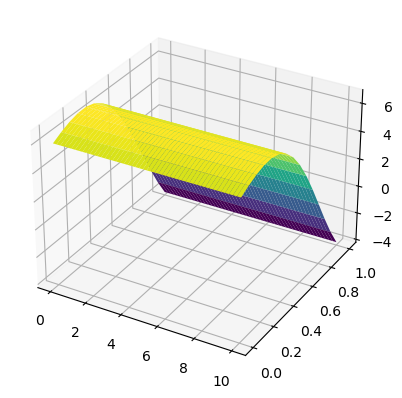

In [7]:
X, Y = np.meshgrid(y,x)
print(X.shape)
print(Y.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(X, Y, U[:,:,10], cmap='viridis')

In [8]:
print(U.shape)

(15, 50, 110)


In [9]:
S = np.zeros((mx,mt,n))
S = U
dx = abs(x[0]-x[1])
dt = abs(y[0]-y[1])
alpha = 0.01

for d in range(n):
    for t in range(1, mt-1):
        for i in range(1,mx-1):
            S[i, t + 1, d] = U[i, t, d] + alpha * (U[i + 1, t, d] - 2 * U[i, t, d] + U[i - 1, t, d]) * (dt / dx**2)

(15, 50)
(15, 50)


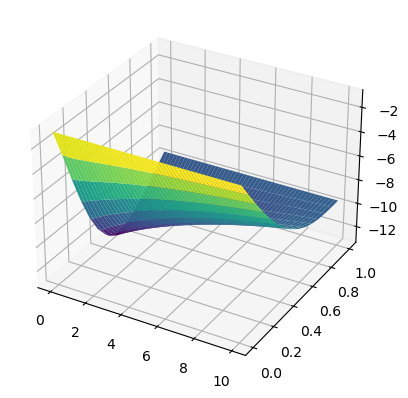

In [10]:
X, Y = np.meshgrid(y,x)
print(X.shape)
print(Y.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(X, Y, S[:,:,1], cmap='viridis')

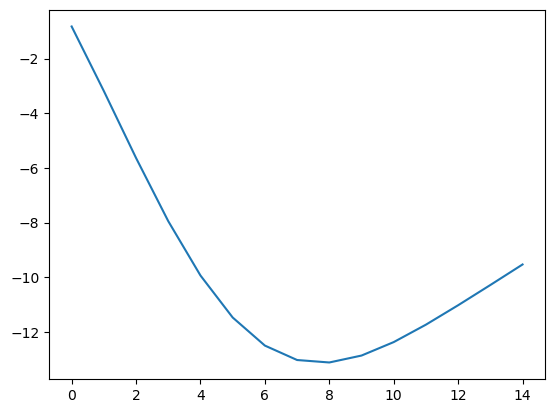

In [11]:
plt.plot(U_in[:,1])

In [12]:
x.shape, y.shape, S.shape, U_in.shape

((15,), (50,), (15, 50, 110), (15, 110))

In [13]:
combinations = []

for i in range(len(x)):
    for j in range(len(y)):
        combinations.append((x[i], y[j]))
        
combinations = np.array(combinations)
print(combinations.shape)
print(combinations)

(750, 2)
[[ 0.          0.        ]
 [ 0.          0.20408163]
 [ 0.          0.40816327]
 ...
 [ 1.          9.59183673]
 [ 1.          9.79591837]
 [ 1.         10.        ]]


In [14]:
x = combinations

In [15]:
x_space = np.linspace(0, x_range, mx)
y_space = np.linspace(0, y_range, mt)

In [16]:
def interate_dataset(mx=mx, mt=mt, n=n, x=x,U_in=U_in, U=U, S=S):
    us = np.zeros((mx*mt*n, mx))
    xs = np.zeros((mx*mt*n, 2))
    ss = np.zeros((mx*mt*n, 1))
    count = 0
    for i in range(n):
        for j in range(mx):
            for jj in range(mt):
                us[count,:] = U_in[:,i]
                xs[count] = [x_space[j],y_space[jj]]
                ss[count] = S[j, jj, i]
                count = count+1
                
    return us, xs, ss

In [17]:
us,xs,ss = interate_dataset()

In [18]:
us.shape, xs.shape, ss.shape

((82500, 15), (82500, 2), (82500, 1))

In [19]:
#us
#xs
#ss

In [20]:
def batch_dataset(batch_size, mx=mx, mt=mt, n=n, x=x, U=U, S=S, ratio=0.8):
    us, xs, ss = interate_dataset(mx,mt,n,x,U_in,U,S)
    
    train_size = int(len(us)*ratio)
    
    us_train = us[:train_size]
    xs_train = xs[:train_size]
    ss_train = ss[:train_size]
    
    us_test = us[train_size:]
    xs_test = xs[train_size:]
    ss_test = ss[train_size:]
    
    us_train = torch.tensor(us_train, dtype= torch.float32)
    xs_train = torch.tensor(xs_train, dtype= torch.float32)
    ss_train = torch.tensor(ss_train, dtype= torch.float32)
    train_dataset = torch.utils.data.TensorDataset(us_train,xs_train,ss_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    us_test = torch.tensor(us_test, dtype= torch.float32)
    xs_test = torch.tensor(xs_test, dtype= torch.float32)
    ss_test = torch.tensor(ss_test, dtype= torch.float32)
    test_dataset = torch.utils.data.TensorDataset(us_test,xs_test,ss_test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    
    return train_dataloader, test_dataloader

In [21]:
train_data, test_data = batch_dataset(batch_size=32, mx=mx, mt=mt, n=n, x=x, U=U, S=S, ratio=0.8)

In [22]:
for u_in_, x_, s_ in train_data:
    print(u_in_.shape, x_.shape, s_.shape )
    break

torch.Size([32, 15]) torch.Size([32, 2]) torch.Size([32, 1])


In [34]:
import torch.nn as nn

class DeepONet(nn.Module):
    def __init__(self, neurons=40, in1 = mx, in2= 2, output_neurons =20):
        super(DeepONet, self).__init__()
        self.neurons = neurons
        self.duble_neurons = 2*neurons
        self.in1 = in1
        self.in2 = in2
        self.output_neurons = output_neurons
        self.branch = self.branch_network()
        self.trunk = self.trunk_network()
        
    def branch_network(self):
        branch = nn.Sequential(
            nn.Linear(self.in1,self.duble_neurons),
            nn.ReLU(),
            nn.Linear(self.duble_neurons,self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons,self.output_neurons),
        )
        return branch
        
    def trunk_network(self):
        trunk=nn.Sequential(
            nn.Linear(self.in2,self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons,self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons,self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons,self.output_neurons),
        )
        return trunk
        
    def forward(self, x1, x2):
        x1 = self.branch(x1)
        x2 = self.trunk(x2)
        x = torch.einsum("bi, bi->b", x1,x2)
        x = torch.unsqueeze(x,1)
        return x

In [35]:
model = DeepONet(neurons=40, in1 = mx, in2= 2, output_neurons =20)

In [36]:
model

DeepONet(
  (branch): Sequential(
    (0): Linear(in_features=15, out_features=80, bias=True)
    (1): ReLU()
    (2): Linear(in_features=80, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=20, bias=True)
  )
)

In [37]:
def loss(y_pred, y):
    return torch.mean((y_pred-y)**2)

In [38]:
#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.001)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
import torch.nn as nn
import torch.optim as optim

train_looses = []

def closure():
    optimizer.zero_grad()
    l_total = 0
    
    for u_, x_, s_ in train_data:
        model.train()
        y_pred = model(u_, x_)
        l = loss(y_pred, s_)
        l_total += l.item()
        l.backward()
    
    l_total = l_total/ len(train_data)
    train_looses.append(l_total)
    
    return l_total

epochs = 600

for i in range(epochs):
    optimizer.step(closure)
    
    if i%20 == 0:
        print("Epoch", i, " / ", epochs, "loss ", train_looses[-1])


Epoch 0  /  600 loss  54.65882448334169
Epoch 20  /  600 loss  14.615585330153229
Epoch 40  /  600 loss  10.457985149791272
Epoch 60  /  600 loss  8.84332590327353
Epoch 80  /  600 loss  2.415819524418539
Epoch 100  /  600 loss  1.3036028469180923
Epoch 120  /  600 loss  1.1753267186016234
Epoch 140  /  600 loss  1.0891854052426915
Epoch 160  /  600 loss  1.0114421536274691
Epoch 180  /  600 loss  0.9594472958099132
Epoch 200  /  600 loss  0.9067149392202302
Epoch 220  /  600 loss  0.8479844090130164
Epoch 240  /  600 loss  0.7863353090311103
Epoch 260  /  600 loss  0.7335747374213557
Epoch 280  /  600 loss  0.6836972730184607
Epoch 300  /  600 loss  0.603317332929393
Epoch 320  /  600 loss  0.4426968256377272
Epoch 340  /  600 loss  0.242192690755939
Epoch 360  /  600 loss  0.15733928100842037
Epoch 380  /  600 loss  0.12854871692761627
Epoch 400  /  600 loss  0.1144266744368627
Epoch 420  /  600 loss  0.10493631333914476
Epoch 440  /  600 loss  0.09796548663569461
Epoch 460  /  600 l

Text(0, 0.5, 'Loss (MSE)')

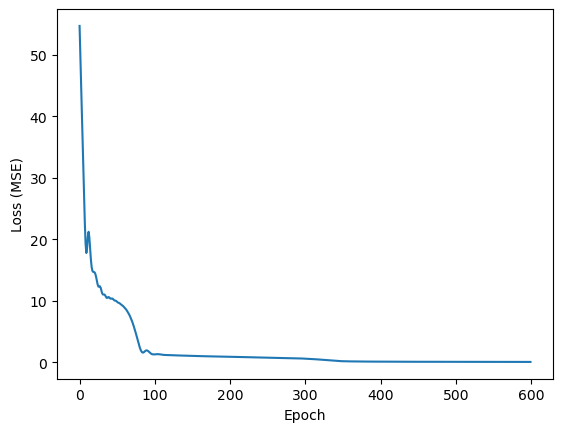

In [41]:
plt.plot(train_looses)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")

In [42]:
mx = 15
mt = 50
n = 110
x_range = 1
y_range = 10

In [43]:
x_gen = np.linspace(0, x_range, mx)
y_gen = np.linspace(0, y_range, mt)

In [49]:
seed = MasterRNG(321)
def one_function(x):
    model = Gaussian(dim=1, var=50, len_scale=0.6)
    srf= SRF(model, seed=seed())
    f = srf.structured([x])
    return f

In [50]:
UU_in = np.zeros((mx,n))
UU = np.zeros((mx,mt,n))

for nn in range(n):
    x_values = one_function(x_gen)
    UU_in[:,nn] = x_values
    for tt in range(mt):
        UU[:,tt,nn] = x_values

In [74]:
# change the number here if want to see more
target_result = 6
################################################


U_gen = UU_in[:,target_result]

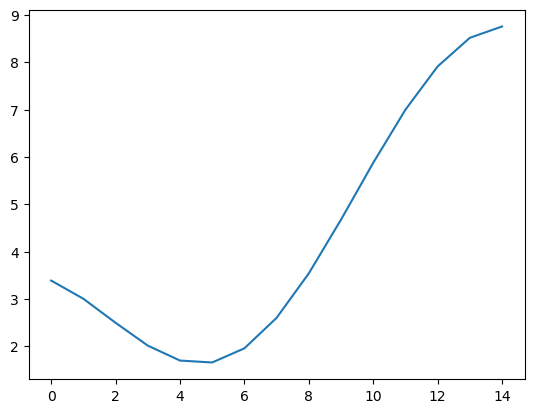

In [75]:
plt.plot(U_gen)

In [76]:
model.eval()
print(U_gen.shape)

(15,)


In [77]:
U_gen = torch.tensor(U_gen, dtype=torch.float32).unsqueeze(0)

In [78]:
x

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.20408163],
       [ 0.        ,  0.40816327],
       ...,
       [ 1.        ,  9.59183673],
       [ 1.        ,  9.79591837],
       [ 1.        , 10.        ]])

In [79]:
x_train = torch.tensor(x, dtype=torch.float32)

In [80]:
p = model(U_gen, x_train)

In [81]:
p = p.detach().numpy()

In [82]:
p.shape

(750, 1)

In [83]:
p_reshape = p.reshape(mx, mt)

In [84]:
p_reshape.shape

(15, 50)

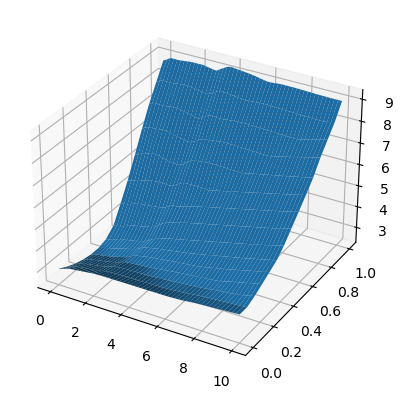

In [85]:
X, Y = np.meshgrid(y_gen,x_gen)
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(X, Y, p_reshape)

In [86]:
S = np.zeros((mx,mt,n))
S = UU
dx = abs(x_gen[0]-x_gen[1])
dt = abs(y_gen[0]-y_gen[1])
alpha = 0.01

for d in range(n):
    for t in range(1, mt-1):
        for i in range(1,mx-1):
            S[i, t + 1, d] = UU[i, t, d] + alpha * (UU[i + 1, t, d] - 2 * UU[i, t, d] + UU[i - 1, t, d]) * (dt / dx**2)

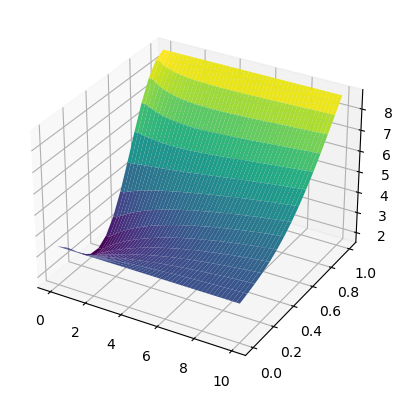

In [87]:
X, Y = np.meshgrid(y_gen,x_gen)

fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(X, Y, S[:,:,target_result], cmap='viridis')

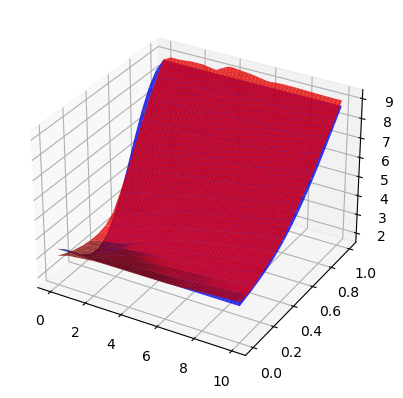

In [88]:
X, Y = np.meshgrid(y_gen,x_gen)

fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')

ax.plot_surface(X, Y, S[:,:,target_result], alpha=0.8, color = 'b')

ax.plot_surface(X, Y, p_reshape, alpha=0.8, color = 'r')

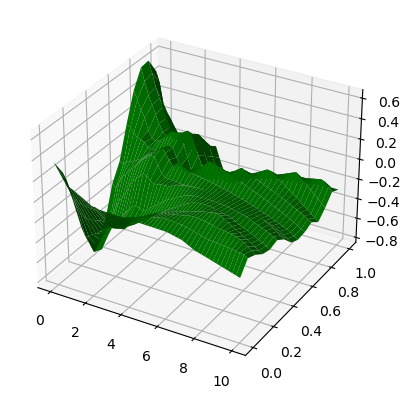

In [89]:
X, Y = np.meshgrid(y_gen,x_gen)

fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')

ax.plot_surface(X, Y, S[:,:,target_result]-p_reshape, alpha=1, color = 'g')